In [1]:
import torch
import torchvision
import torchvision.models
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

e:\python\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'E:\python\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 选择训练所需的设备,GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

using cuda:0 device.


In [3]:
# 数据处理
data_transform = { 
    "train": transforms.Compose([transforms.RandomResizedCrop(120),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
    "val": transforms.Compose([transforms.Resize((120, 120)),  # cannot 224, must (224, 224)
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])}

In [4]:
def Data_processing():
    # 训练集
    train_data = torchvision.datasets.ImageFolder(root = "./data/train" ,   transform = data_transform["train"])
    traindata = DataLoader(dataset=train_data, batch_size=128, shuffle=True, num_workers=0)  # 将训练数据以每次32张图片的形式抽出进行训练
    
    #验证集
    test_data = torchvision.datasets.ImageFolder(root = "./data/val" , transform = data_transform["val"])
    testdata = DataLoader(dataset=test_data, batch_size=128, shuffle=True, num_workers=0)  # 将训练数据以每次32张图片的形式抽出进行测试

    train_size = len(train_data)  # 训练集的长度
    test_size = len(test_data)  # 测试集的长度
    print('train_size',train_size)   #输出训练集长度看一下，相当于看看有几张图片
    print('test_size',test_size)    #输出测试集长度看一下，相当于看看有几张图片

    return traindata, testdata


In [5]:
class BasicBlock(nn.Module): # basic残差块
    expansion = 1 # 扩张大小

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x): # 前向传播（残差块）
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x) # 恒等映射

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [6]:
class Bottleneck(nn.Module): # 瓶颈残差块
    # width_per_group = 8, groups = 32 分组卷积Resnext架构
    expansion = 4 # 扩张大小

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups # 深度

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # 压缩通道squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # 解压缩通道 unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x): # 前向传播
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x) # 恒等映射

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module): # v1.5版本
    def __init__(self,
                 block,  # 残差块类型
                 blocks_num, # 各类型的残差块数量
                 num_classes=1000, # 分类种类
                 include_top=True, # 是否包含最顶层
                 groups=1, # 分组
                 width_per_group=64): # 分组维度
        super(ResNet, self).__init__()

        self.include_top = include_top
        self.in_channel = 64 # 输入通道数，深度

        self.groups = groups 
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)  # 卷积层(1)
        self.bn1 = nn.BatchNorm2d(self.in_channel) # BN层, 用于各通道标准化
        self.relu = nn.ReLU(inplace=True) # 激活函数ReLU
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1) # 最大池化层
        self.layer1 = self._make_layer(block, 64, blocks_num[0],stride=2) # 残差块（1）,共blocks_num[0]个, 3个
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2) # 残差块（2）,共blocks_num[1]个, 4个
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2) # 残差块（3）,共blocks_num[2]个, 6个
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2) # 残差块（4）,共blocks_num[3]个, 3个
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # 自适应平均池化, output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes) # 线性变换

        for m in self.modules():
            if isinstance(m, nn.Conv2d): # 判断该层是否为二维卷积层
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # 进行权重初始化

    def _make_layer(self, block, channel, block_num, stride=1): # 构造残差块
        downsample = None # 是否下采样
        if stride != 1 or self.in_channel != channel * block.expansion: # 当维度不配时，即残差块与残块之间的连接问题
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion)) # 下采样

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1) # 展平变成一维
            x = self.fc(x) # 变成指定维度

        return x

In [8]:
def resnet34(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet50-19c8e357.pth
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=1000, include_top=True):
    # https://download.pytorch.org/models/resnet101-5d3b4d8f.pth
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=1000, include_top=True): # 改进版：分组卷积32x4d
    # https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=1000, include_top=True): # 改进版：分组卷积32x4d
    # https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)

In [9]:
def model_train(net, traindata, testdata, epoch=100):
    
    learning = 0.001  # 学习率
    optimizer = torch.optim.Adam(net.parameters(), lr=learning)  # 使用Adam优化器-写论文的话可以具体查一下这个优化器的原理
    loss = nn.CrossEntropyLoss()  # 损失计算方式，交叉熵损失函数

    train_loss_all = []  # 存放训练集损失的数组
    train_accur_all = []  # 存放训练集准确率的数组
    test_loss_all = []  # 存放测试集损失的数组
    test_accur_all = []  # 存放测试集准确率的数组
    for i in range(epoch):  #开始迭代
        train_loss = 0   #训练集的损失初始设为0
        train_num = 0.0   #
        train_accuracy = 0.0  #训练集的准确率初始设为0
        net.train()   #将模型设置成 训练模式
        train_bar = tqdm(traindata)  #用于进度条显示，没啥实际用处
        for step, data in enumerate(train_bar):  #开始迭代跑， enumerate这个函数不懂可以查查，将训练集分为 data和序号，data是数据
            img, target = data    #将data 分位 img图片，target标签
            optimizer.zero_grad()  # 清空历史梯度
            outputs = net(img.to(device))  # 将图片打入网络进行训练,outputs是输出的结果

            loss1 = loss(outputs, target.to(device))  # 计算神经网络输出的结果outputs与图片真实标签target的差别-这就是我们通常情况下称为的损失
            outputs = torch.argmax(outputs, 1)   #会输出10个值，最大的值就是我们预测的结果 求最大值
            loss1.backward()   #神经网络反向传播
            optimizer.step()  #梯度优化 用上面的adam优化
            train_loss += abs(loss1.item()) * img.size(0)  #将所有损失的绝对值加起来
            accuracy = torch.sum(outputs == target.to(device))   #outputs == target的 即使预测正确的，统计预测正确的个数,从而计算准确率
            train_accuracy = train_accuracy + accuracy   #求训练集的准确率
            train_num += img.size(0)  #

        print("epoch：{} ， train-Loss：{} , train-accuracy：{}".format(i + 1, train_loss / train_num,   #输出训练情况
                                                                    train_accuracy / train_num))
        train_loss_all.append(train_loss / train_num)   #将训练的损失放到一个列表里 方便后续画图
        train_accur_all.append(train_accuracy.double().item() / train_num)#训练集的准确率
        test_loss = 0   #同上 测试损失
        test_accuracy = 0.0  #测试准确率
        test_num = 0
        net.eval()   #将模型调整为测试模型
        with torch.no_grad():  #清空历史梯度，进行测试  与训练最大的区别是测试过程中取消了反向传播
            test_bar = tqdm(testdata)
            for data in test_bar:
                img, target = data

                outputs = net(img.to(device))
                loss2 = loss(outputs, target.to(device))
                outputs = torch.argmax(outputs, 1)
                test_loss = test_loss + abs(loss2.item()) * img.size(0)
                accuracy = torch.sum(outputs == target.to(device))
                test_accuracy = test_accuracy + accuracy
                test_num += img.size(0)

        print("test-Loss：{} , test-accuracy：{}".format(test_loss / test_num, test_accuracy / test_num))
        test_loss_all.append(test_loss / test_num)
        test_accur_all.append(test_accuracy.double().item() / test_num)
        
    return train_loss_all, test_loss_all, train_accur_all, test_accur_all

In [13]:
traindata, testdata = Data_processing() # 数据预处理
epoch = 10  # 迭代次数即训练次数
net = resnet34()
net.to(device)
print(net.to(device)) # 输出模型结构

train_size 517
test_size 58
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(2, 2), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BasicBloc

  0%|          | 0/1 [00:00<?, ?it/s]

epoch：1 ， train-Loss：4.498218342575391 , train-accuracy：0.3094777762889862


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：2.793555736541748 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：2 ， train-Loss：0.7354711140839229 , train-accuracy：0.5125725269317627


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：1.0063116550445557 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：3 ， train-Loss：0.7370820476653728 , train-accuracy：0.5183752775192261


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：3.3101236820220947 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：4 ， train-Loss：0.7084874194871987 , train-accuracy：0.5145067572593689


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：1.7811228036880493 , test-accuracy：0.3103448152542114


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：5 ， train-Loss：0.6759775826271545 , train-accuracy：0.5667311549186707


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7186484336853027 , test-accuracy：0.4482758641242981


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：6 ， train-Loss：0.7122147670105763 , train-accuracy：0.5454545617103577


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7823474407196045 , test-accuracy：0.6896551847457886


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：7 ， train-Loss：0.6899703456308671 , train-accuracy：0.591876208782196


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7662313580513 , test-accuracy：0.4655172526836395


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：8 ， train-Loss：0.6495241611561877 , train-accuracy：0.6382979154586792


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.716750979423523 , test-accuracy：0.5344827771186829


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：9 ， train-Loss：0.7032783833878183 , train-accuracy：0.5938104391098022


  0%|          | 0/5 [00:00<?, ?it/s]

test-Loss：0.7687196135520935 , test-accuracy：0.41379308700561523


  0%|          | 0/1 [00:00<?, ?it/s]

epoch：10 ， train-Loss：0.7107934239293436 , train-accuracy：0.5531914830207825


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


test-Loss：0.7185152173042297 , test-accuracy：0.43103447556495667


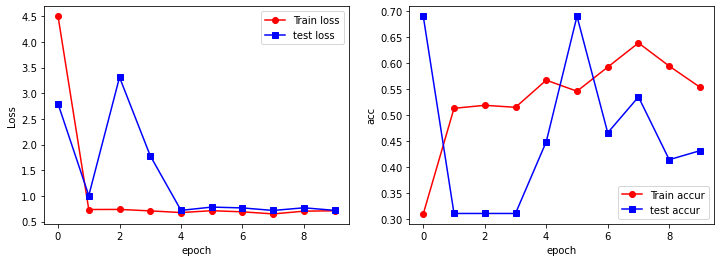

模型已保存


In [14]:
train_loss_all, test_loss_all, train_accur_all, test_accur_all = model_train(net,traindata, testdata, epoch) # 模型训练

#下面的是画图过程，将上述存放的列表  画出来即可
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(epoch), train_loss_all,
         "ro-", label="Train loss")
plt.plot(range(epoch), test_loss_all,
         "bs-", label="test loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("Loss")
plt.subplot(1, 2, 2)
plt.plot(range(epoch), train_accur_all,
         "ro-", label="Train accur")
plt.plot(range(epoch), test_accur_all,
         "bs-", label="test accur")
plt.xlabel("epoch")
plt.ylabel("acc")
plt.legend()
plt.show()

torch.save(net.state_dict(), "Resnet34.pth")
print("模型已保存")